In [ ]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install ffmpeg pydub
from pydub import AudioSegment

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=d03b99797c13223d0e5610aaedc14de5b5881bb0420777f388886f7d9a2331da
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


Audio loaded with shape: (103654,), Sample rate: 16000


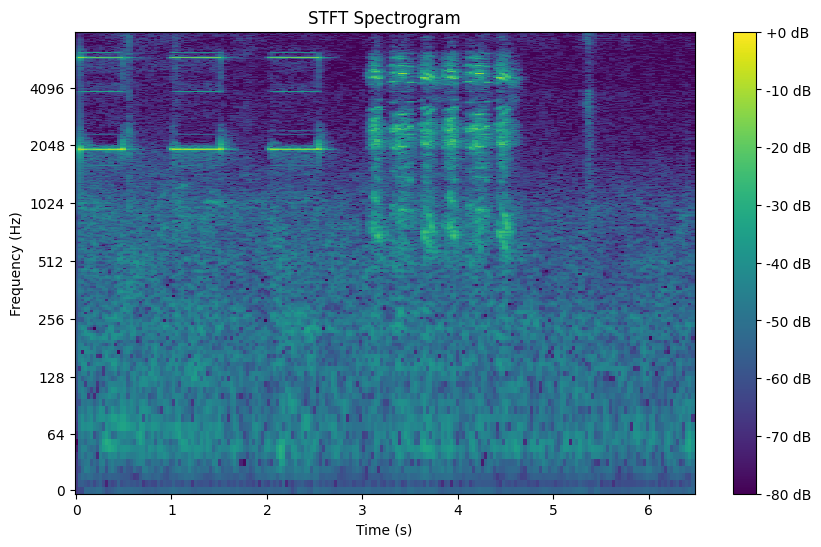

In [ ]:
# 데이터 경로 설정
audio_path = '/content/drive/My Drive/rawdata/화재/가스경보기2.m4a'  # 원하는 오디오 파일 경로
sample_rate = 16000  # 샘플링 레이트

# 오디오 파일 읽기
def load_audio(file_path, sr):
    if file_path.endswith('.m4a'):
        from pydub import AudioSegment
        audio = AudioSegment.from_file(file_path, format="m4a")
        audio = audio.set_frame_rate(sr).set_channels(1)  # 모노로 변환
        samples = np.array(audio.get_array_of_samples()).astype(np.float32)
        samples = samples / np.max(np.abs(samples))  # 정규화
        return samples, sr
    else:
        return librosa.load(file_path, sr=sr)

# 오디오 로드
audio, sr = load_audio(audio_path, sample_rate)
print(f"Audio loaded with shape: {audio.shape}, Sample rate: {sr}")

# STFT 계산
n_fft = 2048  # FFT 크기
hop_length = 512  # Hop length
stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# STFT 그래프 그리기
plt.figure(figsize=(10, 6))
librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
from pydub import AudioSegment
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 데이터 경로 설정
input_base_path = '/content/drive/My Drive/rawdata'  # 원본 데이터 폴더
output_base_path = '/content/drive/My Drive/spectrogram_dataset'  # 저장 경로
categories = ['화재', '대피아닌 것']  # 클래스 이름

# 파라미터 설정
sample_rate = 16000  # 샘플링 레이트
target_duration = 15  # 목표 길이 (초)
n_fft = 2048  # FFT 크기
hop_length = 512  # STFT hop length

# STFT 데이터 저장 경로 생성
if not os.path.exists(output_base_path):
    os.makedirs(output_base_path)
    for category in categories:
        category_path = os.path.join(output_base_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

# 오디오 데이터 길이를 15초로 맞추는 함수
def pad_or_trim(audio, sr, target_duration):
    """
    오디오 데이터를 target_duration(초)으로 패딩 또는 자르기.

    Args:
        audio (numpy array): 오디오 신호 데이터.
        sr (int): 샘플링 레이트.
        target_duration (int): 목표 시간 (초).

    Returns:
        numpy array: 길이가 고정된 오디오 데이터.
    """
    target_length = int(target_duration * sr)  # 목표 샘플 수
    if len(audio) > target_length:
        return audio[:target_length]
    elif len(audio) < target_length:
        padding = target_length - len(audio)
        return np.pad(audio, (0, padding), mode='constant')
    return audio

# 오디오 파일 로드 함수
def load_audio(file_path, sr):
    """오디오 파일 로드 및 정규화"""
    if file_path.endswith('.m4a'):
        # pydub으로 m4a 파일 읽기
        audio = AudioSegment.from_file(file_path, format="m4a")
        audio = audio.set_frame_rate(sr).set_channels(1)  # 샘플링 레이트 및 모노 변환
        samples = np.array(audio.get_array_of_samples()).astype(np.float32)
        samples = samples / np.max(np.abs(samples))  # 정규화
        return samples, sr
    else:
        # librosa로 wav 파일 읽기
        return librosa.load(file_path, sr=sr)

# STFT 데이터 생성 및 저장
for category in categories:
    input_folder = os.path.join(input_base_path, category)
    output_folder = os.path.join(output_base_path, category)

    print(f"Processing category: {category}")
    for file in tqdm(os.listdir(input_folder)):
        if file.endswith('.m4a') or file.endswith('.wav'):
            try:
                file_path = os.path.join(input_folder, file)
                print(f"Processing file: {file_path}")

                # 오디오 로드
                audio, sr = load_audio(file_path, sample_rate)

                # 오디오 길이 15초로 맞추기
                audio = pad_or_trim(audio, sr, target_duration)

                # STFT 계산
                stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
                stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

                # 데이터 저장
                output_file = os.path.join(output_folder, os.path.splitext(file)[0] + '.npy')
                np.save(output_file, stft_db)
                print(f"Saved STFT data to: {output_file}")
            except Exception as e:
                print(f"Error processing {file}: {e}")

print("STFT processing and saving complete!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing category: 화재


  0%|          | 0/189 [00:00<?, ?it/s]

Processing file: /content/drive/My Drive/rawdata/화재/화재경보.m4a


  1%|          | 1/189 [00:00<00:59,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/경보소리.m4a


  1%|          | 2/189 [00:00<00:56,  3.30it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경보소리.npy
Processing file: /content/drive/My Drive/rawdata/화재/소화전 경보음.m4a


  2%|▏         | 3/189 [00:00<00:54,  3.40it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/소화전 경보음.npy
Processing file: /content/drive/My Drive/rawdata/화재/소화전 경보음2.m4a


  2%|▏         | 4/189 [00:01<00:55,  3.34it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/소화전 경보음2.npy
Processing file: /content/drive/My Drive/rawdata/화재/소화전 3.m4a


  3%|▎         | 5/189 [00:01<00:54,  3.41it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/소화전 3.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기.m4a


  3%|▎         | 6/189 [00:01<00:54,  3.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기5.m4a


  4%|▎         | 7/189 [00:02<00:54,  3.36it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기5.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기4.m4a


  4%|▍         | 8/189 [00:02<00:53,  3.37it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기4.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기6.m4a


  5%|▍         | 9/189 [00:02<00:53,  3.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기6.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보큼6.m4a


  5%|▌         | 10/189 [00:02<00:52,  3.44it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보큼6.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재 경보7.m4a


  6%|▌         | 11/189 [00:03<00:53,  3.34it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재 경보7.npy
Processing file: /content/drive/My Drive/rawdata/화재/경보소리2.m4a


  6%|▋         | 12/189 [00:03<00:52,  3.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경보소리2.npy
Processing file: /content/drive/My Drive/rawdata/화재/비상벨 소리1.m4a


  7%|▋         | 13/189 [00:03<00:51,  3.40it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/비상벨 소리1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보2.m4a


  7%|▋         | 14/189 [00:04<00:50,  3.44it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보2.npy
Processing file: /content/drive/My Drive/rawdata/화재/소방비상벨.m4a


  8%|▊         | 15/189 [00:04<00:51,  3.41it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/소방비상벨.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기3.m4a


  8%|▊         | 16/189 [00:04<00:50,  3.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기3.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보4.m4a


  9%|▉         | 17/189 [00:05<00:50,  3.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보4.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보5-1.m4a


 10%|▉         | 18/189 [00:05<00:49,  3.43it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보5-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보6.m4a


 10%|█         | 19/189 [00:05<00:48,  3.48it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보6.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보5.m4a


 11%|█         | 20/189 [00:05<00:49,  3.44it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보5.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보6 (1).m4a


 11%|█         | 21/189 [00:06<00:47,  3.51it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보6 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 (2).m4a


 12%|█▏        | 22/189 [00:06<00:49,  3.41it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 (2).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재지하철.m4a


 12%|█▏        | 23/189 [00:06<00:50,  3.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재지하철.npy
Processing file: /content/drive/My Drive/rawdata/화재/기차 화재.m4a


 13%|█▎        | 24/189 [00:07<00:51,  3.21it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/기차 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/노래방 화재.m4a


 13%|█▎        | 25/189 [00:07<00:50,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/노래방 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/교실 화재.m4a


 14%|█▍        | 26/189 [00:07<00:49,  3.30it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/교실 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/매화초 화재경보.m4a


 14%|█▍        | 27/189 [00:08<00:50,  3.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/매화초 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/건물내 화재.m4a


 15%|█▍        | 28/189 [00:08<00:53,  3.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/건물내 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/자다가 화재.m4a


 15%|█▌        | 29/189 [00:08<01:02,  2.57it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/자다가 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/실시간 화재.m4a


 16%|█▌        | 30/189 [00:09<01:11,  2.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/실시간 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/휴게소 화재경보.m4a


 16%|█▋        | 31/189 [00:09<01:09,  2.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/휴게소 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/실시간 화재 (1).m4a


 17%|█▋        | 32/189 [00:10<01:12,  2.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/실시간 화재 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/콘레드 화재경보.m4a


 17%|█▋        | 33/189 [00:10<01:11,  2.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/콘레드 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/새벽에 울린 화재경보.m4a


 18%|█▊        | 34/189 [00:11<01:09,  2.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/새벽에 울린 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/지하철 화재.m4a


 19%|█▊        | 35/189 [00:11<01:09,  2.20it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/지하철 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/봉은사역 화재.m4a


 19%|█▉        | 36/189 [00:12<01:08,  2.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/봉은사역 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/김포공항 화재경보.m4a


 20%|█▉        | 37/189 [00:12<01:08,  2.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/김포공항 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/임시소방시설 화재.m4a


 20%|██        | 38/189 [00:13<01:13,  2.05it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/임시소방시설 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/신도림역 화재.m4a


 21%|██        | 39/189 [00:13<01:05,  2.31it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/신도림역 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 오작동.m4a


 21%|██        | 40/189 [00:13<01:00,  2.46it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 오작동.npy
Processing file: /content/drive/My Drive/rawdata/화재/국제학교 화재.m4a


 22%|██▏       | 41/189 [00:14<00:55,  2.69it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/국제학교 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/더우니 화재경보.m4a


 22%|██▏       | 42/189 [00:14<00:51,  2.85it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/더우니 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/군자역.m4a


 23%|██▎       | 43/189 [00:14<00:50,  2.89it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/군자역.npy
Processing file: /content/drive/My Drive/rawdata/화재/방재실 화재경보.m4a


 23%|██▎       | 44/189 [00:15<00:48,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/방재실 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/공항철도 화재.m4a


 24%|██▍       | 45/189 [00:15<00:46,  3.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공항철도 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/지하주차장 화재경보.m4a


 24%|██▍       | 46/189 [00:15<00:47,  3.03it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/지하주차장 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/주택용 화재경보기.m4a


 25%|██▍       | 47/189 [00:16<00:45,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/주택용 화재경보기.npy
Processing file: /content/drive/My Drive/rawdata/화재/아파트 화재.m4a


 25%|██▌       | 48/189 [00:16<00:46,  3.05it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/아파트 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/아파트 화재-1.m4a


 26%|██▌       | 49/189 [00:16<00:45,  3.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/아파트 화재-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/마트 화재.m4a


 26%|██▋       | 50/189 [00:17<00:44,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/마트 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/수원역 사이렌.m4a


 27%|██▋       | 51/189 [00:17<00:43,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/수원역 사이렌.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기 (2).m4a


 28%|██▊       | 52/189 [00:17<00:42,  3.20it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기 (2).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재 건물.m4a


 28%|██▊       | 53/189 [00:18<00:43,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재 건물.npy
Processing file: /content/drive/My Drive/rawdata/화재/지하주차장화재.m4a


 29%|██▊       | 54/189 [00:18<00:42,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/지하주차장화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/공항철.m4a


 29%|██▉       | 55/189 [00:18<00:40,  3.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공항철.npy
Processing file: /content/drive/My Drive/rawdata/화재/이케아 화재경보.m4a


 30%|██▉       | 56/189 [00:18<00:41,  3.21it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/이케아 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재감지기.m4a


 30%|███       | 57/189 [00:19<00:40,  3.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재감지기.npy
Processing file: /content/drive/My Drive/rawdata/화재/Mbn 화재.m4a


 31%|███       | 58/189 [00:19<00:40,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/Mbn 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/시민방송 화재.m4a


 31%|███       | 59/189 [00:19<00:39,  3.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/시민방송 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/넘버뤈.m4a


 32%|███▏      | 60/189 [00:20<00:39,  3.30it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/넘버뤈.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보-1.m4a


 32%|███▏      | 61/189 [00:20<00:41,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/경보2.m4a


 33%|███▎      | 62/189 [00:20<00:40,  3.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경보2.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보3.m4a


 33%|███▎      | 63/189 [00:21<00:38,  3.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보3.npy
Processing file: /content/drive/My Drive/rawdata/화재/경보3.m4a


 34%|███▍      | 64/189 [00:21<00:38,  3.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경보3.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재 애기.m4a


 34%|███▍      | 65/189 [00:21<00:38,  3.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재 애기.npy
Processing file: /content/drive/My Drive/rawdata/화재/상가 화재경보.m4a


 35%|███▍      | 66/189 [00:22<00:37,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/상가 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기-1.m4a


 35%|███▌      | 67/189 [00:22<00:36,  3.30it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재발생.m4a


 36%|███▌      | 68/189 [00:22<00:35,  3.37it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재발생.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재-1.m4a


 37%|███▋      | 69/189 [00:22<00:35,  3.36it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재-2.m4a


 37%|███▋      | 70/189 [00:23<00:35,  3.35it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보-2.m4a


 38%|███▊      | 71/189 [00:23<00:37,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/비상벨.m4a


 38%|███▊      | 72/189 [00:24<00:47,  2.45it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/비상벨.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 (1).m4a


 39%|███▊      | 73/189 [00:24<00:47,  2.43it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기 (1).m4a


 39%|███▉      | 74/189 [00:25<00:48,  2.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 애기.m4a


 40%|███▉      | 75/189 [00:25<00:49,  2.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 애기.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 오작동 (1).m4a


 40%|████      | 76/189 [00:25<00:49,  2.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 오작동 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보-1 (1).m4a


 41%|████      | 77/189 [00:26<00:46,  2.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보-1 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기-1 (1).m4a


 41%|████▏     | 78/189 [00:26<00:45,  2.45it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기-1 (1).npy
Processing file: /content/drive/My Drive/rawdata/화재/화재.m4a


 42%|████▏     | 79/189 [00:27<00:44,  2.45it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보고양이.m4a


 42%|████▏     | 80/189 [00:27<00:46,  2.36it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보고양이.npy
Processing file: /content/drive/My Drive/rawdata/화재/동매역 화재경보.m4a


 43%|████▎     | 81/189 [00:28<00:48,  2.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/동매역 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재경보.m4a


 43%|████▎     | 82/189 [00:28<00:46,  2.32it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보1.m4a


 44%|████▍     | 83/189 [00:28<00:43,  2.46it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재!.m4a


 44%|████▍     | 84/189 [00:29<00:39,  2.64it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재!.npy
Processing file: /content/drive/My Drive/rawdata/화재/주차중 화재경보.m4a


 45%|████▍     | 85/189 [00:29<00:37,  2.81it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/주차중 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 강아지.m4a


 46%|████▌     | 86/189 [00:29<00:35,  2.89it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 강아지.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재경보-1.m4a


 46%|████▌     | 87/189 [00:30<00:33,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재경보-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보 호주.m4a


 47%|████▋     | 88/189 [00:30<00:33,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보 호주.npy
Processing file: /content/drive/My Drive/rawdata/화재/아파트 다른동 화재경보기.m4a


 47%|████▋     | 89/189 [00:30<00:35,  2.85it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/아파트 다른동 화재경보기.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보가2.m4a


 48%|████▊     | 90/189 [00:31<00:32,  3.00it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보가2.npy
Processing file: /content/drive/My Drive/rawdata/화재/상가화제.m4a


 48%|████▊     | 91/189 [00:31<00:32,  3.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/상가화제.npy
Processing file: /content/drive/My Drive/rawdata/화재/서울 지하철 화재경보.m4a


 49%|████▊     | 92/189 [00:31<00:30,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/서울 지하철 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/서울 지하철 홪9.m4a


 49%|████▉     | 93/189 [00:31<00:29,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/서울 지하철 홪9.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보기-2.m4a


 50%|████▉     | 94/189 [00:32<00:28,  3.35it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보기-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/아파트 화재경보.m4a


 50%|█████     | 95/189 [00:32<00:27,  3.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/아파트 화재경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/프랑크푸르트 공항 화제경보.m4a


 51%|█████     | 96/189 [00:32<00:29,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/프랑크푸르트 공항 화제경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/프랑크푸르트 화제.m4a


 51%|█████▏    | 97/189 [00:33<00:28,  3.26it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/프랑크푸르트 화제.npy
Processing file: /content/drive/My Drive/rawdata/화재/화제겅보-1.m4a


 52%|█████▏    | 98/189 [00:33<00:27,  3.32it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화제겅보-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화제겅보-2.m4a


 52%|█████▏    | 99/189 [00:33<00:26,  3.43it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화제겅보-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/화제경보사이렌3.m4a


 53%|█████▎    | 100/189 [00:34<00:25,  3.52it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화제경보사이렌3.npy
Processing file: /content/drive/My Drive/rawdata/화재/화제걍보.m4a


 53%|█████▎    | 101/189 [00:34<00:25,  3.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화제걍보.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보-1-1.m4a


 54%|█████▍    | 102/189 [00:34<00:26,  3.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보-1-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/화재경보-1 (2).m4a


 54%|█████▍    | 103/189 [00:34<00:25,  3.36it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/화재경보-1 (2).npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재알람.m4a


 55%|█████▌    | 104/189 [00:35<00:25,  3.34it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재알람.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 3.m4a


 56%|█████▌    | 105/189 [00:35<00:26,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 3.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재2.m4a


 56%|█████▌    | 106/189 [00:36<00:28,  2.92it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재2.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 학교 알람.m4a


 57%|█████▋    | 107/189 [00:36<00:26,  3.06it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 학교 알람.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 알람.m4a


 57%|█████▋    | 108/189 [00:36<00:26,  3.04it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 알람.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 알람4.m4a


 58%|█████▊    | 109/189 [00:37<00:27,  2.89it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 알람4.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람5.m4a


 58%|█████▊    | 110/189 [00:37<00:26,  2.93it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람5.npy
Processing file: /content/drive/My Drive/rawdata/화재/외국화재.m4a


 59%|█████▊    | 111/189 [00:37<00:27,  2.82it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/외국화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/영국 화재알람.m4a


 59%|█████▉    | 112/189 [00:38<00:28,  2.69it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/영국 화재알람.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람.m4a


 60%|█████▉    | 113/189 [00:38<00:28,  2.62it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재4.m4a


 60%|██████    | 114/189 [00:39<00:32,  2.32it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재4.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재.m4a


 61%|██████    | 115/189 [00:39<00:31,  2.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람-1.m4a


 61%|██████▏   | 116/189 [00:39<00:31,  2.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 알람2.m4a


 62%|██████▏   | 117/189 [00:40<00:34,  2.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 알람2.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화제 11.m4a


 62%|██████▏   | 118/189 [00:41<00:33,  2.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화제 11.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화제경보10.m4a


 63%|██████▎   | 119/189 [00:41<00:32,  2.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화제경보10.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화제 12.m4a


 63%|██████▎   | 120/189 [00:41<00:31,  2.22it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화제 12.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화제 13.m4a


 64%|██████▍   | 121/189 [00:42<00:32,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화제 13.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 14.m4a


 65%|██████▍   | 122/189 [00:42<00:30,  2.20it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 14.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 알람 14.m4a


 65%|██████▌   | 123/189 [00:43<00:30,  2.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 알람 14.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 15.m4a


 66%|██████▌   | 124/189 [00:43<00:28,  2.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 15.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재 16.m4a


 66%|██████▌   | 125/189 [00:43<00:25,  2.49it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재 16.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재 16-1.m4a


 67%|██████▋   | 126/189 [00:44<00:23,  2.73it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재 16-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 17.m4a


 67%|██████▋   | 127/189 [00:44<00:21,  2.90it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 17.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 18.m4a


 68%|██████▊   | 128/189 [00:44<00:21,  2.89it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 18.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 19.m4a


 68%|██████▊   | 129/189 [00:45<00:20,  2.92it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 19.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람20.m4a


 69%|██████▉   | 130/189 [00:45<00:19,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람20.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 21.m4a


 69%|██████▉   | 131/189 [00:45<00:18,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 21.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 22.m4a


 70%|██████▉   | 132/189 [00:46<00:18,  3.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 22.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 23.m4a


 70%|███████   | 133/189 [00:46<00:17,  3.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 23.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 24.m4a


 71%|███████   | 134/189 [00:46<00:17,  3.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 24.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 25.m4a


 71%|███████▏  | 135/189 [00:47<00:17,  3.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 25.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 26.m4a


 72%|███████▏  | 136/189 [00:47<00:16,  3.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 26.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 29.m4a


 72%|███████▏  | 137/189 [00:47<00:15,  3.30it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 29.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 27.m4a


 73%|███████▎  | 138/189 [00:48<00:15,  3.26it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 27.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 28.m4a


 74%|███████▎  | 139/189 [00:48<00:15,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 28.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 30.m4a


 74%|███████▍  | 140/189 [00:48<00:15,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 30.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 31.m4a


 75%|███████▍  | 141/189 [00:48<00:15,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 31.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국알람 32.m4a


 75%|███████▌  | 142/189 [00:49<00:14,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국알람 32.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재알람 33.m4a


 76%|███████▌  | 143/189 [00:49<00:14,  3.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재알람 33.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람 34.m4a


 76%|███████▌  | 144/189 [00:49<00:13,  3.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람 34.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람 34-1.m4a


 77%|███████▋  | 145/189 [00:50<00:13,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람 34-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람 34-2.m4a


 77%|███████▋  | 146/189 [00:50<00:13,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람 34-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재알람 35.m4a


 78%|███████▊  | 147/189 [00:50<00:13,  3.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재알람 35.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 알람 37.m4a


 78%|███████▊  | 148/189 [00:51<00:13,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 알람 37.npy
Processing file: /content/drive/My Drive/rawdata/화재/미둑화재알람 36.m4a


 79%|███████▉  | 149/189 [00:51<00:12,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미둑화재알람 36.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 37.m4a


 79%|███████▉  | 150/189 [00:51<00:12,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 37.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 38.m4a


 80%|███████▉  | 151/189 [00:52<00:12,  3.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 38.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 39.m4a


 80%|████████  | 152/189 [00:52<00:11,  3.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 39.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 40.m4a


 81%|████████  | 153/189 [00:52<00:11,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 40.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국화재 40-1.m4a


 81%|████████▏ | 154/189 [00:53<00:10,  3.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국화재 40-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/미국 화재 41.m4a


 82%|████████▏ | 155/189 [00:53<00:10,  3.21it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/미국 화재 41.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보.m4a


 83%|████████▎ | 156/189 [00:53<00:10,  3.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보1.m4a


 83%|████████▎ | 157/189 [00:54<00:12,  2.65it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보1.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보 2.m4a


 84%|████████▎ | 158/189 [00:54<00:12,  2.48it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보 2.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보3.m4a


 84%|████████▍ | 159/189 [00:55<00:12,  2.35it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보3.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습굥보5.m4a


 85%|████████▍ | 160/189 [00:55<00:12,  2.31it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습굥보5.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보6.m4a


 85%|████████▌ | 161/189 [00:56<00:12,  2.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보6.npy
Processing file: /content/drive/My Drive/rawdata/화재/경계경보.m4a


 86%|████████▌ | 162/189 [00:56<00:12,  2.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경계경보.npy
Processing file: /content/drive/My Drive/rawdata/화재/경계경보-1.m4a


 86%|████████▌ | 163/189 [00:57<00:12,  2.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경계경보-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보 3.m4a


 87%|████████▋ | 164/189 [00:57<00:11,  2.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보 3.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보 7.m4a


 87%|████████▋ | 165/189 [00:57<00:11,  2.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보 7.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보8.m4a


 88%|████████▊ | 166/189 [00:58<00:11,  2.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보8.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보9.m4a


 88%|████████▊ | 167/189 [00:58<00:10,  2.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보9.npy
Processing file: /content/drive/My Drive/rawdata/화재/공습경보10.m4a


 89%|████████▉ | 168/189 [00:59<00:08,  2.37it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/공습경보10.npy
Processing file: /content/drive/My Drive/rawdata/화재/가스누설경보기.m4a


 89%|████████▉ | 169/189 [00:59<00:07,  2.61it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/가스누설경보기.npy
Processing file: /content/drive/My Drive/rawdata/화재/가스경보기2.m4a


 90%|████████▉ | 170/189 [00:59<00:06,  2.74it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/가스경보기2.npy
Processing file: /content/drive/My Drive/rawdata/화재/가스누출3.m4a


 90%|█████████ | 171/189 [01:00<00:06,  2.94it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/가스누출3.npy
Processing file: /content/drive/My Drive/rawdata/화재/가스누설경보기2.m4a


 91%|█████████ | 172/189 [01:00<00:05,  3.03it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/가스누설경보기2.npy
Processing file: /content/drive/My Drive/rawdata/화재/자동차 클락션1.m4a


 92%|█████████▏| 173/189 [01:00<00:05,  3.06it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/자동차 클락션1.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션2.m4a


 92%|█████████▏| 174/189 [01:01<00:04,  3.25it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션2.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션3.m4a


 93%|█████████▎| 175/189 [01:01<00:04,  3.33it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션3.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션3-1.m4a


 93%|█████████▎| 176/189 [01:01<00:03,  3.42it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션3-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션 5.m4a


 94%|█████████▎| 177/189 [01:01<00:03,  3.47it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션 5.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션3-2.m4a


 94%|█████████▍| 178/189 [01:02<00:03,  3.55it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션3-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션4.m4a


 95%|█████████▍| 179/189 [01:02<00:02,  3.52it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션4.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션6.m4a


 95%|█████████▌| 180/189 [01:02<00:02,  3.45it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션6.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션7.m4a


 96%|█████████▌| 181/189 [01:03<00:02,  3.42it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션7.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션8-1.m4a


 96%|█████████▋| 182/189 [01:03<00:02,  3.48it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션8-1.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션8-2.m4a


 97%|█████████▋| 183/189 [01:03<00:01,  3.57it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션8-2.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션8-3.m4a


 97%|█████████▋| 184/189 [01:03<00:01,  3.57it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션8-3.npy
Processing file: /content/drive/My Drive/rawdata/화재/경적소리9.m4a


 98%|█████████▊| 185/189 [01:04<00:01,  3.60it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경적소리9.npy
Processing file: /content/drive/My Drive/rawdata/화재/경적소리10.m4a


 98%|█████████▊| 186/189 [01:04<00:00,  3.53it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/경적소리10.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션11.m4a


 99%|█████████▉| 187/189 [01:04<00:00,  3.51it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션11.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션12.m4a


 99%|█████████▉| 188/189 [01:05<00:00,  3.26it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션12.npy
Processing file: /content/drive/My Drive/rawdata/화재/클락션.m4a


100%|██████████| 189/189 [01:05<00:00,  2.89it/s]


Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/화재/클락션.npy
Processing category: 대피아닌 것


  0%|          | 0/148 [00:00<?, ?it/s]

Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 (3).m4a


  1%|          | 1/148 [00:00<01:30,  1.63it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 (3).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 5.m4a


  1%|▏         | 2/148 [00:02<03:08,  1.29s/it]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 5.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 9.m4a


  2%|▏         | 3/148 [00:02<02:04,  1.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 9.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 10.m4a


  3%|▎         | 4/148 [00:03<01:31,  1.57it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 10.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 7.m4a


  3%|▎         | 5/148 [00:03<01:15,  1.90it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 7.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 6.m4a


  4%|▍         | 6/148 [00:03<01:06,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 6.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 11.m4a


  5%|▍         | 7/148 [00:04<01:05,  2.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 11.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 3.m4a


  5%|▌         | 8/148 [00:04<01:05,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 1.m4a


  6%|▌         | 9/148 [00:05<01:06,  2.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 8.m4a


  7%|▋         | 10/148 [00:05<01:03,  2.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 8.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 4.m4a


  7%|▋         | 11/148 [00:06<01:05,  2.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 4.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 소리 2.m4a


  8%|▊         | 12/148 [00:06<01:02,  2.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 소리 2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 소리.m4a


  9%|▉         | 13/148 [00:06<01:00,  2.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰사이렌소리2.m4a


  9%|▉         | 14/148 [00:07<01:07,  1.98it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰사이렌소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 소방차2.m4a


 10%|█         | 15/148 [00:08<01:06,  2.00it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 소방차2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 5.m4a


 11%|█         | 16/148 [00:08<01:02,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 5.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 소방차3.m4a


 11%|█▏        | 17/148 [00:08<00:59,  2.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 소방차3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 소방차.m4a


 12%|█▏        | 18/148 [00:09<00:59,  2.19it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 소방차.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차.m4a


 13%|█▎        | 19/148 [00:09<00:52,  2.45it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/경찰 사이렌 소리1.m4a


 14%|█▎        | 20/148 [00:09<00:48,  2.66it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/경찰 사이렌 소리1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차 (1).m4a


 14%|█▍        | 21/148 [00:10<00:46,  2.72it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차2.m4a


 15%|█▍        | 22/148 [00:10<00:45,  2.76it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차6.m4a


 16%|█▌        | 23/148 [00:11<00:54,  2.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차6.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차10.m4a


 16%|█▌        | 24/148 [00:11<00:54,  2.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차10.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/구급차사이렌.m4a


 17%|█▋        | 25/148 [00:12<00:54,  2.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/구급차사이렌.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차 사이렌 5.m4a


 18%|█▊        | 26/148 [00:12<00:50,  2.42it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차 사이렌 5.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차 사이렌-1.m4a


 18%|█▊        | 27/148 [00:12<00:47,  2.55it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차 사이렌-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차 사이렌.m4a


 19%|█▉        | 28/148 [00:13<00:48,  2.47it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차 사이렌.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차 사이렌-2.m4a


 20%|█▉        | 29/148 [00:13<00:49,  2.40it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차 사이렌-2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차.m4a


 20%|██        | 30/148 [00:14<00:55,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차-1.m4a


 21%|██        | 31/148 [00:15<01:04,  1.80it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차6.m4a


 22%|██▏       | 32/148 [00:15<01:01,  1.88it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차6.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차7.m4a


 22%|██▏       | 33/148 [00:16<01:03,  1.81it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차7.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/소방차8.m4a


 23%|██▎       | 34/148 [00:17<01:20,  1.41it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/소방차8.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/엠뷸런스2.m4a


 24%|██▎       | 35/148 [00:17<01:16,  1.48it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/엠뷸런스2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/엠뷸런스4-1.m4a


 24%|██▍       | 36/148 [00:18<01:06,  1.69it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/엠뷸런스4-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/엠뷸런스-1.m4a


 25%|██▌       | 37/148 [00:18<01:01,  1.81it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/엠뷸런스-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/엠뷸런스4.m4a


 26%|██▌       | 38/148 [00:19<00:57,  1.92it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/엠뷸런스4.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/엠뷸런스.m4a


 26%|██▋       | 39/148 [00:19<00:53,  2.04it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/엠뷸런스.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상소리 (1).m4a


 27%|██▋       | 40/148 [00:19<00:50,  2.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상소리 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상 (1).m4a


 28%|██▊       | 41/148 [00:20<00:50,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/지하철 (1).m4a


 28%|██▊       | 42/148 [00:20<00:49,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/지하철 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상소리-1 (1).m4a


 29%|██▉       | 43/148 [00:21<00:47,  2.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상소리-1 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/오븐소리 (1).m4a


 30%|██▉       | 44/148 [00:21<00:47,  2.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/오븐소리 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/지하철 소리 (1).m4a


 30%|███       | 45/148 [00:22<00:48,  2.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/지하철 소리 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/쇠유리새.m4a


 31%|███       | 46/148 [00:22<00:48,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/쇠유리새.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/판다.m4a


 32%|███▏      | 47/148 [00:23<00:47,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/판다.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/앵무새.m4a


 32%|███▏      | 48/148 [00:23<00:49,  2.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/앵무새.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뻐꾸기.m4a


 33%|███▎      | 49/148 [00:24<00:47,  2.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뻐꾸기.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뻐꾸기2.m4a


 34%|███▍      | 50/148 [00:24<00:46,  2.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뻐꾸기2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/물개.m4a


 34%|███▍      | 51/148 [00:25<00:48,  1.98it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/물개.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뜸부기.m4a


 35%|███▌      | 52/148 [00:25<00:45,  2.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뜸부기.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뜸부기2.m4a


 36%|███▌      | 53/148 [00:26<00:41,  2.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뜸부기2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/낙타.m4a


 36%|███▋      | 54/148 [00:26<00:37,  2.54it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/낙타.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/돼지.m4a


 37%|███▋      | 55/148 [00:26<00:34,  2.69it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/돼지.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/고래 울음소리.m4a


 38%|███▊      | 56/148 [00:26<00:33,  2.78it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/고래 울음소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/송아지.m4a


 39%|███▊      | 57/148 [00:27<00:31,  2.91it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/송아지.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/아이폰 소리.m4a


 39%|███▉      | 58/148 [00:27<00:29,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/아이폰 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/독수리.m4a


 40%|███▉      | 59/148 [00:27<00:29,  3.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/독수리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/아이폰2.m4a


 41%|████      | 60/148 [00:28<00:28,  3.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/아이폰2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/휴대폰 소리.m4a


 41%|████      | 61/148 [00:28<00:28,  3.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/휴대폰 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/휴대폰 진동음.m4a


 42%|████▏     | 62/148 [00:28<00:27,  3.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/휴대폰 진동음.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/통화끊긴 소리.m4a


 43%|████▎     | 63/148 [00:29<00:27,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/통화끊긴 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/통화종료음.m4a


 43%|████▎     | 64/148 [00:29<00:26,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/통화종료음.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/통화연결음.m4a


 44%|████▍     | 65/148 [00:29<00:25,  3.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/통화연결음.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/학교 종소리.m4a


 45%|████▍     | 66/148 [00:30<00:25,  3.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/학교 종소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/학교 종소리2.m4a


 45%|████▌     | 67/148 [00:30<00:25,  3.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/학교 종소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/학교종소리4.m4a


 46%|████▌     | 68/148 [00:30<00:24,  3.21it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/학교종소리4.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/빗소리.m4a


 47%|████▋     | 69/148 [00:31<00:25,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/빗소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/빗소리2.m4a


 47%|████▋     | 70/148 [00:31<00:25,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/빗소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/빗소리3.m4a


 48%|████▊     | 71/148 [00:31<00:24,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/빗소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뱃고동소리.m4a


 49%|████▊     | 72/148 [00:32<00:24,  3.06it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뱃고동소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뱃고동소리2.m4a


 49%|████▉     | 73/148 [00:32<00:23,  3.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뱃고동소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뱃고동소리3.m4a


 50%|█████     | 74/148 [00:32<00:24,  3.03it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뱃고동소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/학교 종소리3.m4a


 51%|█████     | 75/148 [00:33<00:24,  3.00it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/학교 종소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상소리-1 (2).m4a


 51%|█████▏    | 76/148 [00:33<00:24,  2.99it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상소리-1 (2).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/오븐소리 (2).m4a


 52%|█████▏    | 77/148 [00:33<00:23,  2.97it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/오븐소리 (2).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/지하철 소리 (2).m4a


 53%|█████▎    | 78/148 [00:34<00:23,  2.94it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/지하철 소리 (2).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/사과먹는소리 (1).m4a


 53%|█████▎    | 79/148 [00:34<00:22,  3.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/사과먹는소리 (1).npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/원앙소리.m4a


 54%|█████▍    | 80/148 [00:34<00:21,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/원앙소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/원앙소리2.m4a


 55%|█████▍    | 81/148 [00:34<00:21,  3.05it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/원앙소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/두꺼비소리.m4a


 55%|█████▌    | 82/148 [00:35<00:21,  3.02it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/두꺼비소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/갈매기 소리.m4a


 56%|█████▌    | 83/148 [00:35<00:21,  3.00it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/갈매기 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/고라니 소리.m4a


 57%|█████▋    | 84/148 [00:36<00:24,  2.60it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/고라니 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/늑대울음소리.m4a


 57%|█████▋    | 85/148 [00:36<00:25,  2.43it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/늑대울음소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/매미 소리.m4a


 58%|█████▊    | 86/148 [00:37<00:25,  2.39it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/매미 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/매미소리2.m4a


 59%|█████▉    | 87/148 [00:37<00:25,  2.35it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/매미소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/원숭이.m4a


 59%|█████▉    | 88/148 [00:37<00:25,  2.36it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/원숭이.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/염소소리.m4a


 60%|██████    | 89/148 [00:38<00:27,  2.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/염소소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/부엉이.m4a


 61%|██████    | 90/148 [00:38<00:25,  2.24it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/부엉이.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/코끼리.m4a


 61%|██████▏   | 91/148 [00:39<00:26,  2.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/코끼리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/홍학소리.m4a


 62%|██████▏   | 92/148 [00:39<00:25,  2.17it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/홍학소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/황소개구리소리.m4a


 63%|██████▎   | 93/148 [00:40<00:25,  2.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/황소개구리소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/양소리.m4a


 64%|██████▎   | 94/148 [00:40<00:25,  2.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/양소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/황금새 소리.m4a


 64%|██████▍   | 95/148 [00:41<00:24,  2.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/황금새 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/카나리아 울음소라.m4a


 65%|██████▍   | 96/148 [00:41<00:22,  2.33it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/카나리아 울음소라.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/카나리아 울음소리2.m4a


 66%|██████▌   | 97/148 [00:41<00:20,  2.53it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/카나리아 울음소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/카나리아 울음소리 3.m4a


 66%|██████▌   | 98/148 [00:42<00:18,  2.68it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/카나리아 울음소리 3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/카나리아 울음소리.m4a


 67%|██████▋   | 99/148 [00:42<00:17,  2.79it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/카나리아 울음소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/까치.m4a


 68%|██████▊   | 100/148 [00:42<00:16,  2.91it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/까치.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/닭.m4a


 68%|██████▊   | 101/148 [00:43<00:15,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/닭.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/곰.m4a


 69%|██████▉   | 102/148 [00:43<00:15,  3.01it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/곰.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/큰고니.m4a


 70%|██████▉   | 103/148 [00:43<00:14,  3.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/큰고니.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/개구리.m4a


 70%|███████   | 104/148 [00:44<00:13,  3.16it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/개구리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/개구리2.m4a


 71%|███████   | 105/148 [00:44<00:13,  3.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/개구리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/기타소리.m4a


 72%|███████▏  | 106/148 [00:44<00:13,  3.18it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/기타소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/노래소리.m4a


 72%|███████▏  | 107/148 [00:45<00:13,  3.09it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/노래소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뉴스-1.m4a


 73%|███████▎  | 108/148 [00:45<00:13,  3.07it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뉴스-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뉴스.m4a


 74%|███████▎  | 109/148 [00:45<00:12,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뉴스.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/뉴스-2.m4a


 74%|███████▍  | 110/148 [00:46<00:11,  3.23it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/뉴스-2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/롯데리아 소리.m4a


 75%|███████▌  | 111/148 [00:46<00:11,  3.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/롯데리아 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/롯데리아2-1.m4a


 76%|███████▌  | 112/148 [00:46<00:10,  3.34it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/롯데리아2-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/롯데리아2.m4a


 76%|███████▋  | 113/148 [00:46<00:10,  3.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/롯데리아2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/롯데리아2-2.m4a


 77%|███████▋  | 114/148 [00:47<00:10,  3.33it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/롯데리아2-2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/물소리.m4a


 78%|███████▊  | 115/148 [00:47<00:10,  3.29it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/물소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/물소리2.m4a


 78%|███████▊  | 116/148 [00:47<00:10,  3.14it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/물소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/바람소리1.m4a


 79%|███████▉  | 117/148 [00:48<00:09,  3.20it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/바람소리1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/바람소리3.m4a


 80%|███████▉  | 118/148 [00:48<00:09,  3.04it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/바람소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/바람소리2.m4a


 80%|████████  | 119/148 [00:48<00:09,  3.03it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/바람소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/사과먹는소리.m4a


 81%|████████  | 120/148 [00:49<00:09,  2.99it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/사과먹는소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/베이스 소리.m4a


 82%|████████▏ | 121/148 [00:49<00:08,  3.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/베이스 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/새소리.m4a


 82%|████████▏ | 122/148 [00:49<00:08,  3.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/새소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/악기서리.m4a


 83%|████████▎ | 123/148 [00:50<00:08,  2.98it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/악기서리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/악기소리.m4a


 84%|████████▍ | 124/148 [00:50<00:07,  3.10it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/악기소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/오븐소리.m4a


 84%|████████▍ | 125/148 [00:50<00:07,  3.05it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/오븐소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/월드컵 응원소리.m4a


 85%|████████▌ | 126/148 [00:51<00:06,  3.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/월드컵 응원소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/응원소리.m4a


 86%|████████▌ | 127/148 [00:51<00:07,  2.85it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/응원소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상.m4a


 86%|████████▋ | 128/148 [00:52<00:08,  2.38it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/응원소리-1.m4a


 87%|████████▋ | 129/148 [00:52<00:08,  2.37it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/응원소리-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상소리.m4a


 88%|████████▊ | 130/148 [00:53<00:07,  2.28it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/자전거 클락샹.m4a


 89%|████████▊ | 131/148 [00:53<00:07,  2.35it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/자전거 클락샹.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/일상소리-1.m4a


 89%|████████▉ | 132/148 [00:53<00:07,  2.15it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/일상소리-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/주호민 롯데리아 소리.m4a


 90%|████████▉ | 133/148 [00:54<00:06,  2.21it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/주호민 롯데리아 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/지하철.m4a


 91%|█████████ | 134/148 [00:54<00:06,  2.27it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/지하철.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/지하철 소리.m4a


 91%|█████████ | 135/148 [00:55<00:06,  2.11it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/지하철 소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/풍경소리.m4a


 92%|█████████▏| 136/148 [00:55<00:05,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/풍경소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/파도소리.m4a


 93%|█████████▎| 137/148 [00:56<00:05,  2.12it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/파도소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리1.m4a


 93%|█████████▎| 138/148 [00:56<00:04,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/피아노 소리2.m4a


 94%|█████████▍| 139/148 [00:57<00:04,  2.13it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/피아노 소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리2.m4a


 95%|█████████▍| 140/148 [00:57<00:03,  2.41it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/피아노소리.m4a


 95%|█████████▌| 141/148 [00:57<00:02,  2.64it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/피아노소리.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/피아노소리3.m4a


 96%|█████████▌| 142/148 [00:58<00:02,  2.76it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/피아노소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리2-1.m4a


 97%|█████████▋| 143/148 [00:58<00:01,  2.89it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리2-1.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리3.m4a


 97%|█████████▋| 144/148 [00:58<00:01,  3.08it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리3.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리5.m4a


 98%|█████████▊| 145/148 [00:59<00:01,  2.88it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리5.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/함성소리6.m4a


 99%|█████████▊| 146/148 [00:59<00:00,  2.79it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/함성소리6.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/홈쇼핑2.m4a


 99%|█████████▉| 147/148 [00:59<00:00,  2.86it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/홈쇼핑2.npy
Processing file: /content/drive/My Drive/rawdata/대피아닌 것/홈쇼핑.m4a


100%|██████████| 148/148 [01:00<00:00,  2.46it/s]

Saved STFT data to: /content/drive/My Drive/spectrogram_dataset/대피아닌 것/홈쇼핑.npy
STFT processing and saving complete!


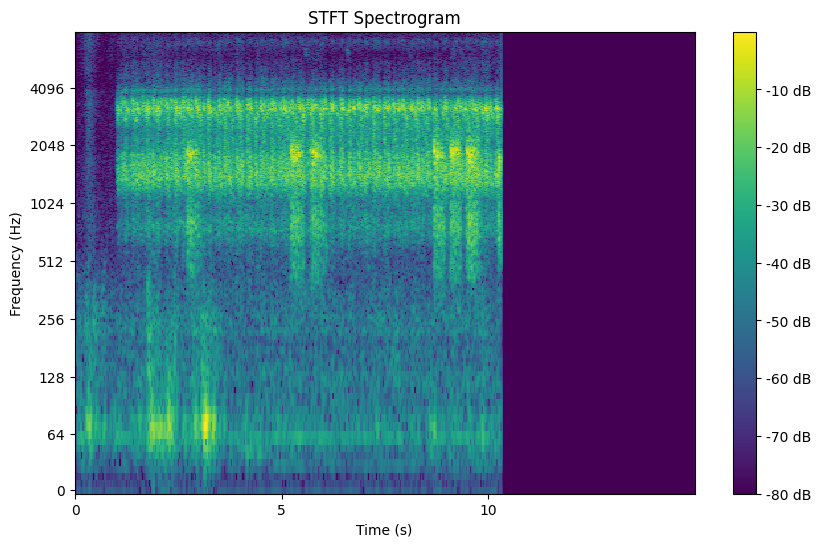

In [ ]:
# STFT 시각화
import matplotlib.pyplot as plt

# 저장된 데이터 로드
sample_file = '/content/drive/My Drive/spectrogram_dataset/대피아닌 것/개구리.npy'
stft_data = np.load(sample_file)

# 그래프 그리기
plt.figure(figsize=(10, 6))
librosa.display.specshow(stft_data, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()
